Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [38]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization

In [2]:
## Mounting the google drive to access data :
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)



Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

root_path = "/content/gdrive/MyDrive/CNN_data/CNN_Melanoma/CNN_assignment"
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [4]:
# Image count in train , test set and total.

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Image in Train set = ",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Image in Test set = ",image_count_test)
print(" Total image = ",image_count_train + image_count_test)

Image in Train set =  2239
Image in Test set =  118
 Total image =  2357


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Creation of train data set using tf.keras.preprocessing.image_dataset_from_directory , seed of 123 and above image size

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Creation of test data set using tf.keras.preprocessing.image_dataset_from_directory , seed of 123 and above image size

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,labels='inferred', validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# Finding the class names in the class_names attribute on these datasets.
# Finding total number of  classes of skin cancer.

class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)
print("Number of Classes = ",num_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Number of Classes =  9


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

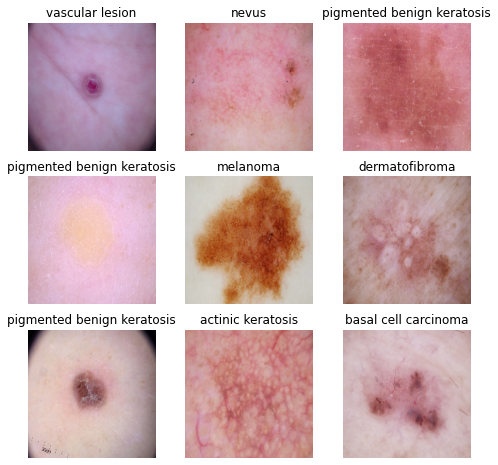

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
  

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Creation
#### Done: Created a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range which is not ideal for a neural network hence  standardize values to be in the range of  `[0, 1]`

In [11]:

preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Creation of model using appropirate optimiser and loss function

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),

  layers.Dense(512, activation='relu'),
  layers.Dense(128, activation='relu'),
  
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View Model summary of all layers

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [14]:
## Train the model using epochs size of 20

epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 522s 2s/step - loss: 2.0964 - accuracy: 0.1953 - val_loss: 2.0178 - val_accuracy: 0.2483
Epoch 2/20
56/56 [==============================] - 3s 54ms/step - loss: 1.9851 - accuracy: 0.2528 - val_loss: 1.8807 - val_accuracy: 0.3445
Epoch 3/20
56/56 [==============================] - 3s 51ms/step - loss: 1.7035 - accuracy: 0.3956 - val_loss: 1.7721 - val_accuracy: 0.3960
Epoch 4/20
56/56 [==============================] - 3s 51ms/step - loss: 1.4771 - accuracy: 0.4888 - val_loss: 1.4478 - val_accuracy: 0.4989
Epoch 5/20
56/56 [==============================] - 3s 52ms/step - loss: 1.3585 - accuracy: 0.5173 - val_loss: 1.4440 - val_accuracy: 0.4989
Epoch 6/20
56/56 [==============================] - 3s 51ms/step - loss: 1.2626 - accuracy: 0.5530 - val_loss: 1.3468 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 3s 51ms/step - loss: 1.2339 - accuracy: 0.5552 - val_loss: 1.3220 - val_accuracy: 0.5414
Epoch 8/20
56

### Visualizing training results

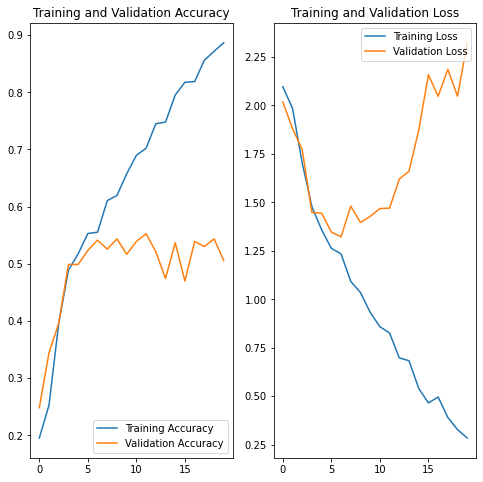

In [15]:
## Visualise the model accuracy and loss on the train and validation set.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings of the model
### Overfit:
From the above accuracy  and loss function diagram, we can see that the model train accuracy is around 88% but when observed on the validation dataset it is around 50%.
From the loss diagram, we can see that the model loss is decreasing continuously with each epoch , it's learning but for the validation set this loss was decreasing at first few epoch then it started increasing which shows that the loss has increased during the testing  on validation set.
To solve this issue we will use the methodology called as "DATA AUGUMENTATION" so that the model gets different combination of images which can help the model to learn properly.

### Data Augumentation

In [16]:
## Code for Data Augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

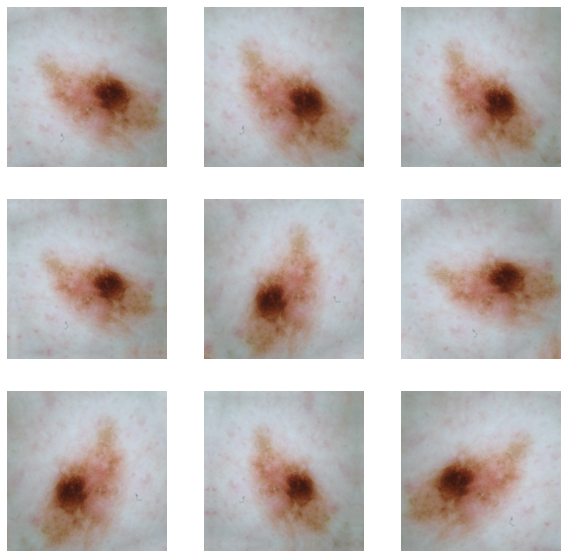

In [17]:
# Visualization of  images after augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [18]:
## Used Dropout layer as  there is an evidence of overfitting in our above findings

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Dropout(0.2),

  layers.Flatten(),

  layers.Dense(512, activation='relu'),
  layers.Dense(128, activation='relu'),

  layers.Dense(num_classes)
])



### Compiling the model

In [19]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

### Training the model

In [20]:
## Training  model using 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 67ms/step - loss: 2.2333 - accuracy: 0.1981 - val_loss: 2.0140 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 4s 63ms/step - loss: 1.8575 - accuracy: 0.3158 - val_loss: 1.7747 - val_accuracy: 0.3669
Epoch 3/20
56/56 [==============================] - 4s 63ms/step - loss: 1.6263 - accuracy: 0.4085 - val_loss: 1.6544 - val_accuracy: 0.4004
Epoch 4/20
56/56 [==============================] - 3s 62ms/step - loss: 1.5694 - accuracy: 0.4381 - val_loss: 1.5558 - val_accuracy: 0.4609
Epoch 5/20
56/56 [==============================] - 4s 63ms/step - loss: 1.5409 - accuracy: 0.4604 - val_loss: 1.5584 - val_accuracy: 0.4765
Epoch 6/20
56/56 [==============================] - 4s 63ms/step - loss: 1.4663 - accuracy: 0.4883 - val_loss: 1.5214 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 4s 63ms/step - loss: 1.4133 - accuracy: 0.4994 - val_loss: 1.4953 - val_accuracy: 0.4855
Epoch 8/20
56

### Visualizing the results

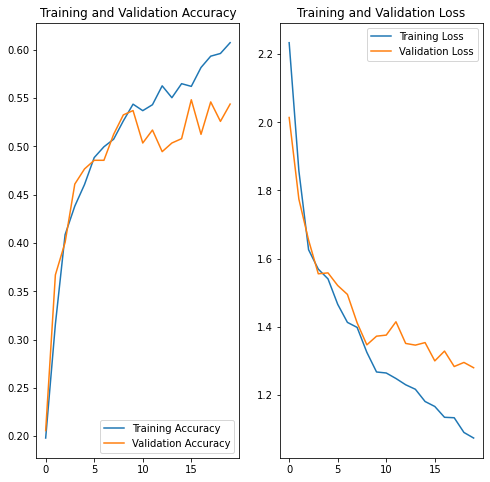

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Observation:** 
###Model is not overfitting but the overall accuracy of the model is low (about 60% on train set and 54% on validation set. There is significant improvement in the model as the currently, it is no longer has "Overfit/Underfit".
### Low accuracy can be resulted due to data imbalance in all the category of the skin cancer type. 


#### Finding the distribution of classes in the training dataset and performed sanity check to know the distribution of classes in the data.


<Figure size 720x720 with 0 Axes>

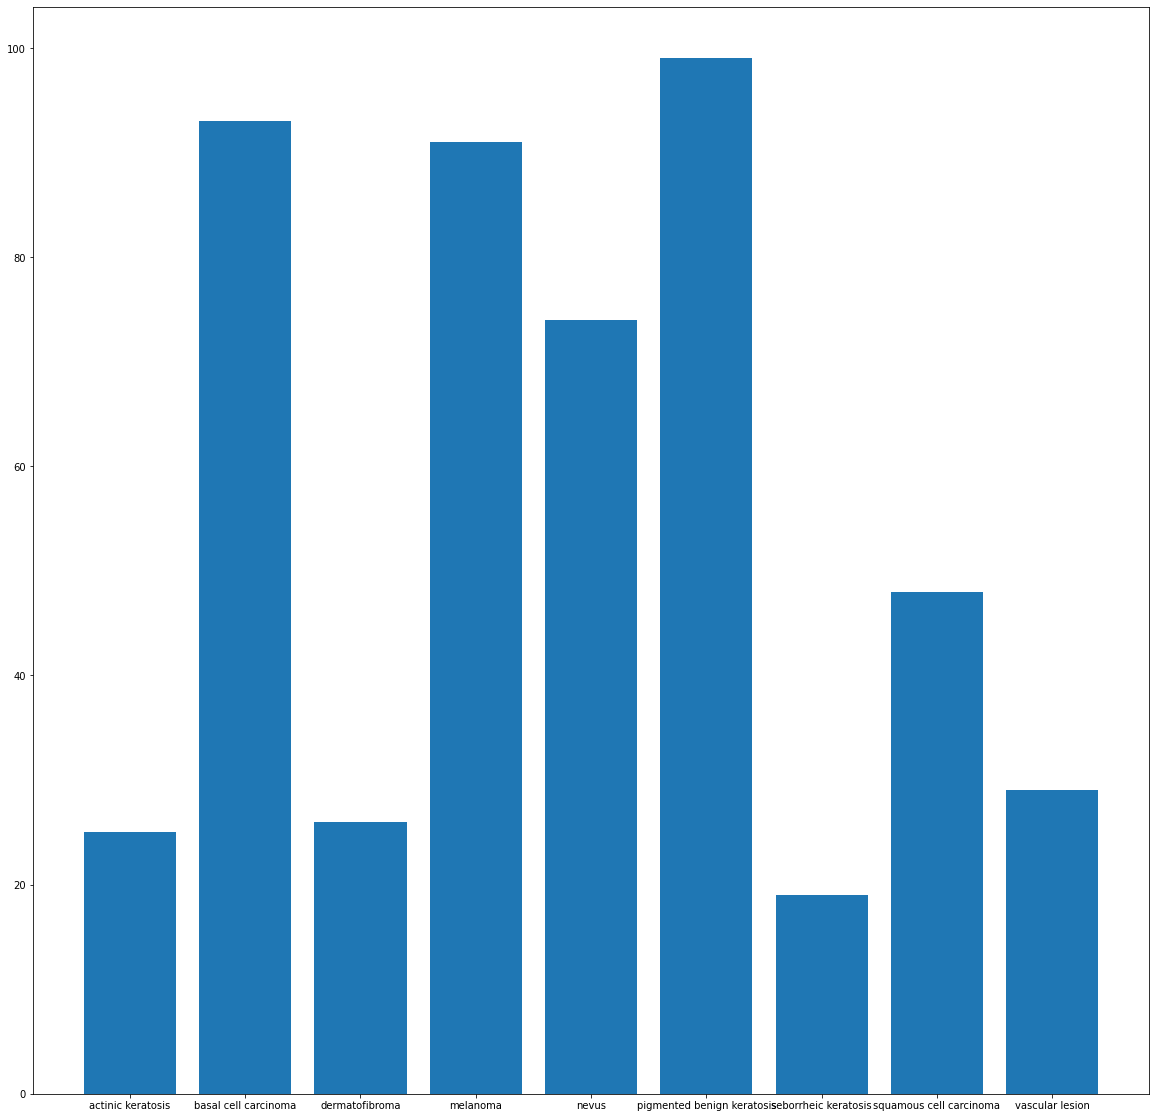

In [22]:

import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### **Obervation:**  
#### - "seborrheic keratosis" has least number of data
#### - "pigmented benign keratosis" has the height number of data


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [23]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [24]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN_data/CNN_Melanoma/CNN_assignment/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_data/CNN_Melanoma/CNN_assignment/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6193534B10>: 100%|██████████| 500/500 [00:23<00:00, 21.31 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_data/CNN_Melanoma/CNN_assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F620C084690>: 100%|██████████| 500/500 [00:24<00:00, 20.30 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_data/CNN_Melanoma/CNN_assignment/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6193531690>: 100%|██████████| 500/500 [00:25<00:00, 19.52 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_data/CNN_Melanoma/CNN_assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F620C084250>: 100%|██████████| 500/500 [01:51<00:00,  4.47 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_data/CNN_Melanoma/CNN_assignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F620BFDEC50>: 100%|██████████| 500/500 [01:39<00:00,  5.04 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_data/CNN_Melanoma/CNN_assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6193502790>: 100%|██████████| 500/500 [00:22<00:00, 22.62 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_data/CNN_Melanoma/CNN_assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F620BD90AD0>: 100%|██████████| 500/500 [00:47<00:00, 10.46 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_data/CNN_Melanoma/CNN_assignment/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F620BFB11D0>: 100%|██████████| 500/500 [00:21<00:00, 22.84 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_data/CNN_Melanoma/CNN_assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F61937A4E10>: 100%|██████████| 500/500 [00:21<00:00, 22.75 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [25]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [26]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/CNN_data/CNN_Melanoma/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027615.jpg_e852fd61-163e-4a60-b3f3-86eefa8146de.jpg',
 '/content/gdrive/MyDrive/CNN_data/CNN_Melanoma/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029041.jpg_cfaa7d53-ca77-4f2f-b989-980fca9240f0.jpg',
 '/content/gdrive/MyDrive/CNN_data/CNN_Melanoma/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030730.jpg_5c105c4c-57b8-4c73-9dfe-5690c9e8259b.jpg',
 '/content/gdrive/MyDrive/CNN_data/CNN_Melanoma/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032206.jpg_1d710b5b-19f8-4500-a866-19a85772c787.jpg',
 '/content/gdrive/MyDrive/CNN_data/CNN_Melanoma/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026626.jpg_5b3b057a-c67b-4988-a6fe-9d0fe1eca5c5.jpg',
 '/content/gdrive/MyDrive/CNN_data/CNN_Melanoma/CNN_assignment/Train/actinic keratosis/output/a

In [27]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [28]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [29]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = (df2)

In [30]:
new_df['Label'].value_counts()

actinic keratosis             500
vascular lesion               500
dermatofibroma                500
seborrheic keratosis          500
squamous cell carcinoma       500
basal cell carcinoma          500
pigmented benign keratosis    500
nevus                         500
melanoma                      500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [31]:
batch_size = 32
img_height = 180
img_width = 180

####  Create a training dataset

In [32]:
data_dir_train="/content/gdrive/MyDrive/CNN_data/CNN_Melanoma/CNN_assignment/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


####  Create a validation dataset

In [33]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


####  Create your model (make sure to include normalization)

In [45]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
 

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),

  layers.Dense(num_classes)
])

####  Compile your model (Choose optimizer and loss function appropriately)

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 90, 90, 16)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 90, 90, 32)        4640      
                                                      

####  Train your model

In [47]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 42s 234ms/step - loss: 1.6818 - accuracy: 0.3744 - val_loss: 3.4999 - val_accuracy: 0.1834
Epoch 2/30
169/169 [==============================] - 40s 230ms/step - loss: 1.4743 - accuracy: 0.4462 - val_loss: 1.8159 - val_accuracy: 0.4246
Epoch 3/30
169/169 [==============================] - 40s 231ms/step - loss: 1.4401 - accuracy: 0.4549 - val_loss: 2.2846 - val_accuracy: 0.3296
Epoch 4/30
169/169 [==============================] - 41s 233ms/step - loss: 1.3708 - accuracy: 0.4924 - val_loss: 2.1413 - val_accuracy: 0.3192
Epoch 5/30
169/169 [==============================] - 41s 234ms/step - loss: 1.3443 - accuracy: 0.4926 - val_loss: 1.5447 - val_accuracy: 0.4165
Epoch 6/30
169/169 [==============================] - 40s 232ms/step - loss: 1.3042 - accuracy: 0.5102 - val_loss: 2.3134 - val_accuracy: 0.2970
Epoch 7/30
169/169 [==============================] - 41s 234ms/step - loss: 1.2725 - accuracy: 0.5213 - val_loss: 1.3518 - val_ac

####   Visualize the model results

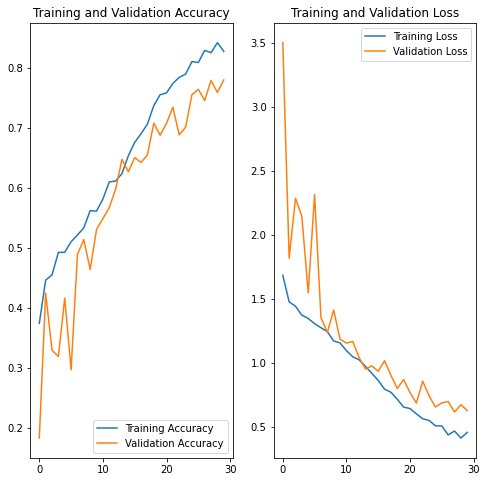

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####   Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



1.From the above model we can conclude that the model is no longer overfitting as the accuracy on the train and test set are 82% and 77% respectively.
2.Data imbalance correction and batch normalisation helped in getting good accuracy without overfit.

In [50]:
data_dir_test = "/content/gdrive/MyDrive/CNN_data/CNN_Melanoma/CNN_assignment/Test/"

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    color_mode='rgb',
    image_size=(img_height, img_width),
    batch_size=batch_size
)
print(test_ds.class_names)

normalised_layer = tf.keras.layers.Rescaling(1./255)
test_ds1 = test_ds.map(lambda x, y: (normalised_layer(x), y))

model.evaluate(test_ds1)

Found 118 files belonging to 9 classes.
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
4/4 [==============================] - 34s 89ms/step - loss: 15.0760 - accuracy: 0.1356


[15.075961112976074, 0.1355932205915451]